# 1. 연매출액 관련 Feature 분석 (이해강)
- 1) 기업별 연매출액 평균 TOP50
- 2) 기업별 연매출액 연평균 성장률 TOP50

In [120]:
# 필요한 라이브러리 import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 경고창 무시
import warnings
warnings.filterwarnings(action='ignore')

# matplotlib 한글 폰트 오류 해결
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='appleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system.... sorry.....')

In [158]:
# 데이터 불러오기
df = pd.read_csv('company_nps_data.csv',encoding='ansi')

# 피벗 테이블로 '연매출액','회사ID','년도' 만 포함된 데이터프레임 생성
ndf = df.pivot_table('연매출액','회사ID','년도')

# 인덱스와 컬럼 자료형 변환
ndf.index = ndf.index.map(lambda x : str(x))
ndf.columns = ndf.columns.map(lambda x : str(x))

# '연평균 성장률' 변수 중 기간(n)을 구하기
# '기간'이라는 칼럼 생성 후 임의의 값 부여
ndf['기간'] = 0

# 한 행씩 접근하며 널값이 아닌 데이터들의 개수를 세서 '기간' 칼럼에 저장
# 그 후 2를 빼줌( "notnull()로 세어진'기간'칼럼" 과 "두 연도의 차이" )   
for i in range(len(ndf)):
    ndf['기간'][i] = ndf.iloc[i].notnull().sum()-2

# 연매출액 평균 구하기
ndf1 = ndf[ndf['기간']!=0]
ndf1 = ndf1.replace(np.nan,0)
ndf1['평균연매출액'] = (ndf1['2015']+ndf1['2016']+ndf1['2017']+ndf1['2018']+ndf1['2019'])/(ndf1['기간']+1)
평균연매출액TOP500 = ndf1['평균연매출액'].sort_values(ascending=False).head(500)

# 연매출액 연평균 성장률을 구하기 위해 2015년과 2019를 기준으로 결측치들을 앞과 뒤의 값들로 채워줌 (기간을 미리구해놨기 때문에 가능)
# '기간' 칼럼 제외한 새로운 데이터프레임으로 복사 (연도의 널값을 채워주기 위해) 
ndf1 = ndf[['2015','2016','2017','2018','2019']]

# 계산의 편의상 시작값(2015로)과 종료값(2019로)을 맞춰주기 위해 널값 채우기
ndf1.T.fillna(method = 'ffill',inplace=True)
ndf1.T.fillna(method = 'bfill',inplace=True)

# 널값 채운 후 다시 '기간'칼럼 붙여주기
ndf1['기간'] = ndf['기간']

# 기간이 0인 데이터들 소거
# 기간이 0이면 1년치의 데이터밖에 없기 때문에 성장률을 알 수가 없기 때문
# 연매출액 데이터가 하나뿐임
ndf1 = ndf1[ndf1['기간'] != 0]

# 연평균 성장률 계산 후, 유니콘 데이터 기준 min()값인 -28.54 미만의 데이터 소거
ndf1['연평균 성장률(%)'] = round(((ndf1['2019']/ndf1['2015'])**(1/ndf1['기간'])-1)*100, 2)
ndf1 = ndf1[ndf1['연평균 성장률(%)'] >= -28.54]

# 유니콘 데이터 기준 연매출액 min() 값인 99100 미만 데이터 소거
ndf1 = ndf1.loc[(ndf1['2015'] >= 99100) & (ndf1['2016'] >= 99100) & (ndf1['2017'] >= 99100) & (ndf1['2018'] >= 99100) & (ndf1['2019'] >= 99100)]

# 1년씩 성장률 계산
ndf1['15-16년 성장률'] = round(((ndf1['2016']-ndf1['2015'])/ndf1['2015'])*100, 1)
ndf1['16-17년 성장률'] = round(((ndf1['2017']-ndf1['2016'])/ndf1['2016'])*100, 1)
ndf1['17-18년 성장률'] = round(((ndf1['2018']-ndf1['2017'])/ndf1['2017'])*100, 1)
ndf1['18-19년 성장률'] = round(((ndf1['2019']-ndf1['2018'])/ndf1['2018'])*100, 1)

# 계산된 성장률의 max()값으로 해당기간 성장률 최고치 계산
ndf1['성장률 최고치']=0.0
for i in range(len(ndf1)):
    ndf1['성장률 최고치'][i]=max(ndf1['15-16년 성장률'][i],ndf1['16-17년 성장률'][i],ndf1['17-18년 성장률'][i],ndf1['18-19년 성장률'][i])
    
# 유니콘 데이터 기준 성장률 최고치 min() 값인 39.2% 미만 데이터 소거
ndf1 = ndf1.loc[ndf1['성장률 최고치']>=39.2]
ndf1 # 최종 데이터가 5000개에서 768개로 줄어든 것을 알 수 있다.

# 연평균 성장률 TOP500 구하기
연매출액성장률TOP500 = ndf1['연평균 성장률(%)'].sort_values(ascending=False).head(500)

### 분석결과 TOP 50 데이터추출

In [168]:
display(평균연매출액TOP500, 연매출액성장률TOP500)
평균연매출액TOP500.to_excel('평균연매출액500.xlsx',encoding='ansi')
연매출액성장률TOP500.to_excel('연매출액성장률500.xlsx',encoding='ansi')
일인당연매출액성장률TOP500.to_excel('일인당연매출액성장률TOP500.xlsx',encoding='ansi')

회사ID
419945    8.353127e+09
227415    5.241049e+09
227414    4.459102e+09
419977    4.252086e+09
294649    3.833816e+09
              ...     
311556    1.415003e+07
129895    1.414430e+07
165163    1.407167e+07
305949    1.406817e+07
427685    1.405150e+07
Name: 평균연매출액, Length: 500, dtype: float64

회사ID
177997    1451.48
237193     979.16
413403     834.29
432907     727.52
206055     700.00
           ...   
241762      24.73
396114      24.50
304307      24.47
140535      24.41
235776      24.39
Name: 연평균 성장률(%), Length: 500, dtype: float64

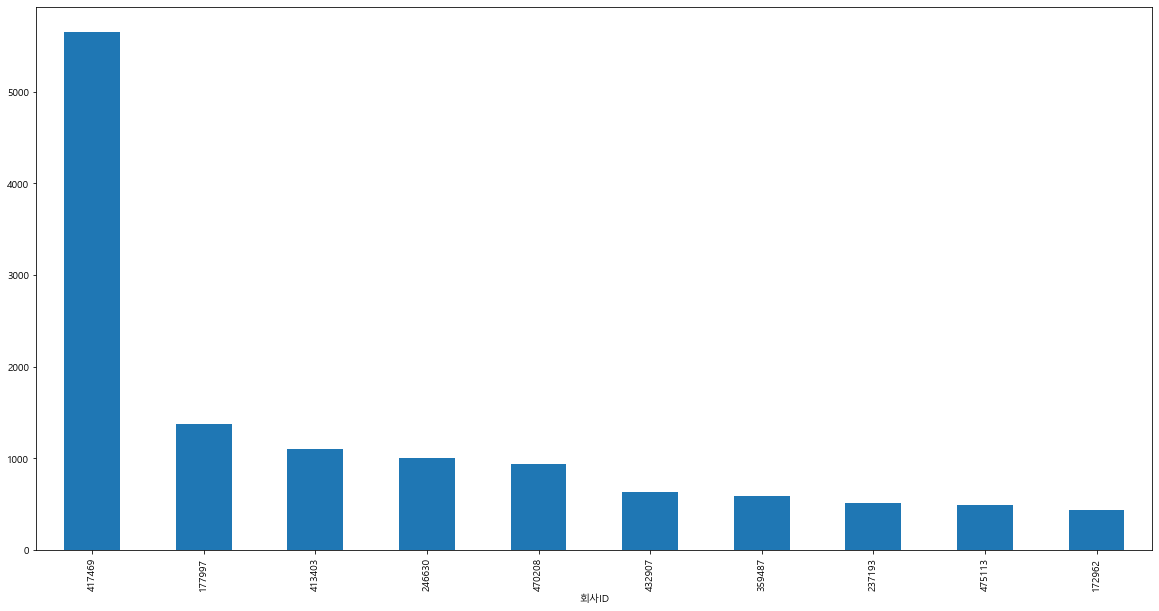

In [156]:
일인당연매출액성장률TOP50.head(10).plot(kind='bar',figsize=(20,10))

# 2. 일인당 연매출액(한사람당 매출액에 얼마만큼 기여하는지) 관련 Feature 분석(이해강)
- 1) 기업별 일인당 연매출액 성장률 TOP50

In [163]:
# 데이터 불러오기
df = pd.read_csv('company_nps_data.csv',encoding='ansi')

# 일인당 매출액 컬럼 생성
df['일인당 매출액'] = round(df['연매출액']/df['월별_직원수'], 2)

# 회사ID와 년도별로 묶어 일인당 매출액의 연평균을 구하기
ndf = df.groupby(['회사ID','년도']).mean()

# 필요한 칼럼들만 추출
ndf.drop(['연매출액','월','월별_연금보험료','월별_직원수'],axis=1,inplace=True)

# 시계열로 나타낼 수 있게 피벗테이블 생성
ndf1 = ndf.pivot_table('일인당 매출액','회사ID','년도')
ndf1.index = ndf1.index.map(lambda x : str(x))
ndf1.columns = ndf1.columns.map(lambda x : str(x))

# '기간'이라는 칼럼 생성 후 임의의 값 부여
ndf1['기간'] = 0

# 한 행씩 접근하며 널값이 아닌 데이터들의 개수를 세서 '기간' 칼럼에 저장
for i in range(len(ndf1)):
    ndf1['기간'][i] = ndf1.iloc[i].notnull().sum()
    
# 그 후 2를 빼줌( "notnull()로 세어진'기간'칼럼" 과 "두 연도의 차이" )    
ndf1['기간']=ndf1['기간']-2

# '기간' 칼럼 제외한 새로운 데이터프레임으로 복사 (연도의 널값을 채워주기 위해) 
ndf2 = ndf1[['2015','2016','2017','2018','2019']]

# 계산의 편의상 시작값(2015로)과 종료값(2019로)을 맞춰주기 위해 널값 채우기
ndf2.T.fillna(method = 'ffill',inplace=True)
ndf2.T.fillna(method = 'bfill',inplace=True)

# 널값 채운 후 다시 '기간'칼럼 붙여주기
ndf2['기간'] = ndf1['기간']

# 기간이 0인 데이터 소거
ndf2 = ndf2[ndf2['기간'] != 0]

# 일인당 매출액의 '연평균 성장률' 컬럼 생성
ndf2['연평균 성장률(%)'] = round(((ndf2['2019']/ndf2['2015'])**(1/ndf2['기간'])-1)*100, 2)

# 유니콘 데이터 기준 '연평균 성장률' ''-44.66% 미만' 데이터 소거
ndf2 = ndf2[ndf2['연평균 성장률(%)'] >= -44.66]

# 유니콘 데이터 기준 '일인당 연매출' '3604.83 미만' 데이터 소거
ndf2 = ndf2.loc[(ndf2['2015'] >= 3604.83) & (ndf2['2016'] >= 3604.83) & (ndf2['2017'] >= 3604.83) & (ndf2['2018'] >= 3604.83) & (ndf2['2019'] >= 3604.83)]

# 일인당 매출액의 '작년 대비 성장률' 컬럼 4개 생성
ndf2['15-16년 성장률'] = round(((ndf2['2016']-ndf2['2015'])/ndf2['2015'])*100, 1)
ndf2['16-17년 성장률'] = round(((ndf2['2017']-ndf2['2016'])/ndf2['2016'])*100, 1)
ndf2['17-18년 성장률'] = round(((ndf2['2018']-ndf2['2017'])/ndf2['2017'])*100, 1)
ndf2['18-19년 성장률'] = round(((ndf2['2019']-ndf2['2018'])/ndf2['2018'])*100, 1)

# 일인당 매출액의 '성장률 최고치' 컬럼 생성
ndf2['성장률 최고치']=0.0
for i in range(len(ndf2)):
    ndf2['성장률 최고치'][i]=max(ndf2['15-16년 성장률'][i],ndf2['16-17년 성장률'][i],ndf2['17-18년 성장률'][i],ndf2['18-19년 성장률'][i])

# 유니콘 데이터 기준 '성장률 최고치'가 23.2% 미만인 데이터 소거
ndf2 = ndf2.loc[ndf2['성장률 최고치']>=23.2]

# 직원수가 0인 컬럼이 있어서, 연매출액을 나눠준뒤 inf값이 생김. 그것을 처리
ndf2 = ndf2.replace(np.inf,np.nan).dropna(axis=0)

# 최종 데이터가 5000개에서 1151개로 줄어든 것을 알 수 있다.
ndf2

# 일인당 연매출액 연평균 성장률 TOP500 추출
일인당연매출액성장률TOP500 = ndf2['연평균 성장률(%)'].sort_values(ascending=False).head(500)

### 분석결과 TOP 50 데이터추출

In [167]:
print(일인당연매출액성장률TOP500.head(10))

회사ID
417469    5646.83
177997    1377.14
413403    1103.88
246630    1002.49
470208     936.55
432907     635.00
359487     589.48
237193     508.90
475113     493.66
172962     439.04
Name: 연평균 성장률(%), dtype: float64
